# Calculate ICC of QAP measures from CORR data
Code to calculate the modern ICC version (using linear mixed-effects model).
A lot is borrowed from AFNI's 3dICC_REML.R. Big shout out to the AFNI folks.

In [40]:
library(lme4)
library(dplyr)
library(reshape2)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)

## Read and tidy the CORR anatomical QAP measures

In [17]:
# read the data
corr_anat_qa<-read.csv("2016_05_CORR_qap_anatomical_spatial.csv")

# reduce to the columns that we are interested in
id.vars=c('Participant','Site','Session','Series')
measure.vars=c('CNR','Cortical.Contrast','EFC','FBER','FWHM','Qi1','SNR')

corr_anat_qa<-corr_anat_qa[c(id.vars,measure.vars)]

In [18]:
# Filter 1
# Use only the first scan from sessions 1 & 2
corr_anat_qa <-  corr_anat_qa %>% 
                  filter(Series == 'anat_1') %>% 
                   filter(Session %in% c('session_1','session_2'))
corr_anat_qa$Series <- droplevels(corr_anat_qa$Series)
corr_anat_qa$Session <- droplevels(corr_anat_qa$Session)

In [20]:
# Filter 2 
# remove participants that do not have two sessions of data
pts_keep <- (corr_anat_qa %>% 
             group_by(Participant) %>% 
              summarise(N=n()) %>%
               filter(N>1))$Participant
corr_anat_qa <-  corr_anat_qa %>% 
                  filter(Participant %in% pts_keep)
# corr_anat_qa$Participant <- droplevels(corr_anat_qa$Participant)

In [21]:
# Filter 3 
# remove Sites that have fewer that 10 pts
sites_keep <- (corr_anat_qa %>% 
                 group_by(Site) %>% 
                   summarise(N=n()) %>%
                     filter(N>10))$Site
corr_anat_qa <-  corr_anat_qa %>% 
                  filter(Site %in% sites_keep)
corr_anat_qa$Site <- droplevels(corr_anat_qa$Site)

In [22]:
table(corr_anat_qa$Site, corr_anat_qa$Session)

         
          session_1 session_2
  BNU_1          50        50
  BNU_2          61        61
  HNU_1          30        30
  IACAS          27        27
  IBA_TRT        14        14
  IPCAS_1        30        30
  IPCAS_2        35        35
  IPCAS_8        13        13
  LMU_3          25        25
  MRN            48        48
  NYU_1          25        25
  NYU_2          62        62
  SWU_1          19        19
  SWU_3          24        24
  SWU_4         234       234
  UM             80        80
  UPSM_1         99        99
  Utah_1         19        19
  UWM            25        25
  XHCUMS         24        24

In [23]:
## make table of session1 vs. session2 scatter plots
df<-melt(corr_anat_qa,
         id.vars=id.vars,
         measure.vars=measure.vars,
         variable.name="Measure")

df <- df %>% spread(Session, value)
head(df)

Participant,Site,Series,Measure,session_1,session_2
25000,NYU_2,anat_1,CNR,11.98814305,12.56221793
25000,NYU_2,anat_1,Cortical.Contrast,0.37586680,0.42267393
25000,NYU_2,anat_1,EFC,0.39672353,0.39002321
25000,NYU_2,anat_1,FBER,398.24758483,344.16062441
25000,NYU_2,anat_1,FWHM,3.28540315,3.31394664
25000,NYU_2,anat_1,Qi1,0.05368263,0.05388648


In [32]:
# QC hand ratings
scatter_plots<-function(df,x_var,y_var,axis_strings,title_strings,pdf_fname,fig_size_w,fig_size_h,ncol,nrow){
    options(repr.plot.width=fig_size_w, repr.plot.height=fig_size_h)
    
#     pdf(pdf_fname, width = fig_size_w, height = fig_size_h, family="ArialMT")
    
    grid.newpage()

    pushViewport(viewport(layout = grid.layout(nrow, ncol)))
    
    vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)

    pval_thresh=c(0.05,0.01,0.001,0.0001)
    pval_indicators=c("*","**","***","****")
        
    measure.vars = unique(df$Measure)

    for (i in seq(1,length(measure.vars)))
    {
        # get only the rows corresponding to this measure
        sdf<- df %>% filter(Measure == measure.vars[i])
        scale_min<-min(sdf[x_var],sdf[y_var])
        scale_max<-max(sdf[x_var],sdf[y_var])
        
#         formula=sprintf("value ~ as.factor(%s)",qc_var)
#         # get the lable and annotate to indicate statistical significance of the difference
#         pval<-wilcox.test(as.formula(formula),data=sdf)$p.value

#         pval_string="ns"
#         for (t in seq(1,length(pval_thresh)))
#         {
#             if(pval < pval_thresh[t])
#             {
#                 pval_string=pval_indicators[t]
#             }
#         }

#         print(paste(measure.vars[i],label_strings[[measure.vars[i]]],pval_string,sprintf('pval %e',pval)))
        
        p<-ggplot(sdf, aes_string(x=x_var, y=y_var, fill=measure.vars[i])) + 
            geom_point(size=.5) + 
            theme_bw() +
            ggtitle(label_strings[[measure.vars[i]]])+
            xlab(axis_strings[[x_var]])+
            ylab(axis_strings[[y_var]])+
            theme(legend.position = "none",
                  plot.title = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 10,
                                             vjust = 0,
                                             hjust = 0.5),
                  axis.text.x = element_text(family = "ArialMT",
                                             face = "plain",
                                             size = 8, 
                                             angle = 0, 
                                             hjust = 0.5),
                  axis.text.y = element_text(family = "ArialMT", 
                                             face = "plain", 
                                             size = 8, 
                                             angle = 90, 
                                             hjust = 0.5),
                  axis.title.y = element_text(family = "ArialMT", 
                                              face = "plain", 
                                              size = 10, 
                                              angle = 90, 
                                              vjust = 0.9),
                  axis.title.x = element_text(family = "ArialMT", 
                                              face = "plain", 
                                              size = 10, 
                                              angle = 0, 
                                              vjust = 0.9),
                  plot.margin = unit(c(.25, .25, 0.25, .25), 
                                     "lines")) +
            coord_fixed(ylim=c(scale_min,scale_max), xlim=c(scale_min,scale_max))
#         +

#             # reduce the range to between the 2% and 98% quartiles to make the plot
#             # range more readible, do this without censoring so that the bars will go
#             # out of frame     
#             coord_cartesian(ylim=with(sdf, val_range))


        # get the location of this plot in the grid
        x=ceiling(i/ncol)
        y=((i-1) %% ncol)+1

        # add the plot to the grid
        print(p, vp = vplayout(x, y))
    }
#     dev.off()
}

In [25]:
# plots
label_strings=c(CNR='CNR',
                Cortical.Contrast='Cortical Contrast',
                EFC='EFC',
                FBER='FBER',
                FWHM='Smoothness (FWHM)',
                Qi1='Fraction of Artifact Voxels',
                SNR='SNR')

axis_strings=list(session_1 = "Session 1", session_2 = "Session 2")

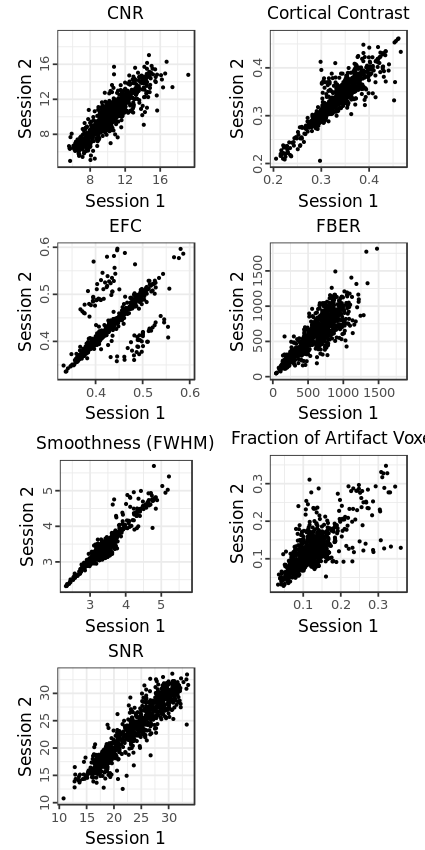

In [26]:
scatter_plots(df,'session_1','session_2',axis_strings, label_strings, 'none',90.0/25.4,2*90.0/25.4,2,4)

In [187]:
max(df$session_1,df$session_2)

[1] 1815.012

In [27]:
# read the data
corr_func_qa<-read.csv("2016_05_CoRR_qap_functional_spatial.csv")

# reduce to the columns that we are interested in
id.vars=c('Participant','Site','Session','Series')
measure.vars=c('EFC','FBER','FWHM','Ghost_y','SNR')
corr_func_qa<-corr_func_qa[c(id.vars,measure.vars)]

# read in the temporal measures
tdf<-read.csv("2016_05_CORR_qap_functional_temporal.csv")
tmeasure.vars=c('Fraction.of.Outliers..Mean.','GCOR','Quality..Mean.',
                'RMSD..Mean.','Std..DVARS..Mean.')
tdf<-tdf[c(id.vars,tmeasure.vars)]

# combine the datasets
corr_func_qa<-merge(corr_func_qa,tdf,by=id.vars)
measure.vars<-c(measure.vars,tmeasure.vars)

# Filter 1
# Use only the first scan from sessions 1 & 2
corr_func_qa <-  corr_func_qa %>% 
                  filter(Series == 'rest_1') %>% 
                   filter(Session %in% c('session_1','session_2'))
corr_func_qa$Series <- droplevels(corr_func_qa$Series)
corr_func_qa$Session <- droplevels(corr_func_qa$Session)

# Filter 2 
# reduce to same participants in anatomical analysis
corr_func_qa <-  corr_func_qa %>% 
                  filter(Participant %in% corr_anat_qa$Participant)
corr_func_qa$Site <- droplevels(corr_func_qa$Site)

# mult table to make a seperate row for each obs of each measure
corr_func_qa <- corr_func_qa %>% 
                  melt(id.vars=id.vars,
                       measure.vars=measure.vars,
                       variable.name="Measure")

# make sure that participant is a factor
corr_func_qa$Participant <- factor(corr_func_qa$Participant)

table(corr_func_qa$Site, corr_func_qa$Session)
head(corr_func_qa)

         
          session_1 session_2
  BNU_1         500       500
  BNU_2         610       610
  HNU_1         300       300
  IACAS         270       270
  IBA_TRT       140       140
  IPCAS_1       300       300
  IPCAS_2       350       350
  IPCAS_8       130       130
  LMU_3         250       250
  MRN           390       420
  NYU_1         250       250
  NYU_2         620       620
  SWU_1         190       190
  SWU_3         240       240
  SWU_4        2330      2330
  UM            800       800
  UPSM_1        990       990
  Utah_1        190       190
  UWM           250       250
  XHCUMS        240       240

Participant,Site,Session,Series,Measure,value
25000,NYU_2,session_1,rest_1,EFC,0.4746275
25000,NYU_2,session_2,rest_1,EFC,0.4655316
25001,NYU_2,session_1,rest_1,EFC,0.4813221
25001,NYU_2,session_2,rest_1,EFC,0.4840581
25002,NYU_2,session_1,rest_1,EFC,0.4525287
25002,NYU_2,session_2,rest_1,EFC,0.4654134


In [28]:
## make table of session1 vs. session2 scatter plots
df <- corr_func_qa %>% spread(Session, value)
head(df)

Participant,Site,Series,Measure,session_1,session_2
25000,NYU_2,rest_1,EFC,0.474627533,0.465531623
25000,NYU_2,rest_1,FBER,20.567237141,23.004120017
25000,NYU_2,rest_1,FWHM,1.848541592,1.926711090
25000,NYU_2,rest_1,Ghost_y,-0.010328280,-0.001600582
25000,NYU_2,rest_1,SNR,11.226366955,11.810273067
25000,NYU_2,rest_1,Fraction.of.Outliers..Mean.,0.002357111,0.002385056


In [29]:
label_strings=list(EFC='EFC',
                   FBER='FBER',
                   FWHM='Smoothness (FWHM)',
                   Ghost_y='GSR',
                   SNR='SNR',
                   Fraction.of.Outliers..Mean.='Mean Fraction of Outliers',
                   GCOR='GCOR',
                   Quality..Mean.='Mean AFNI Quality Index',
                   RMSD..Mean.='Mean RMSD',
                   Std..DVARS..Mean.='Mean Std. DVARS')
axis_strings=list(session_1 = "Session 1", session_2 = "Session 2")

Warning message:
“Removed 13 rows containing missing values (geom_point).”

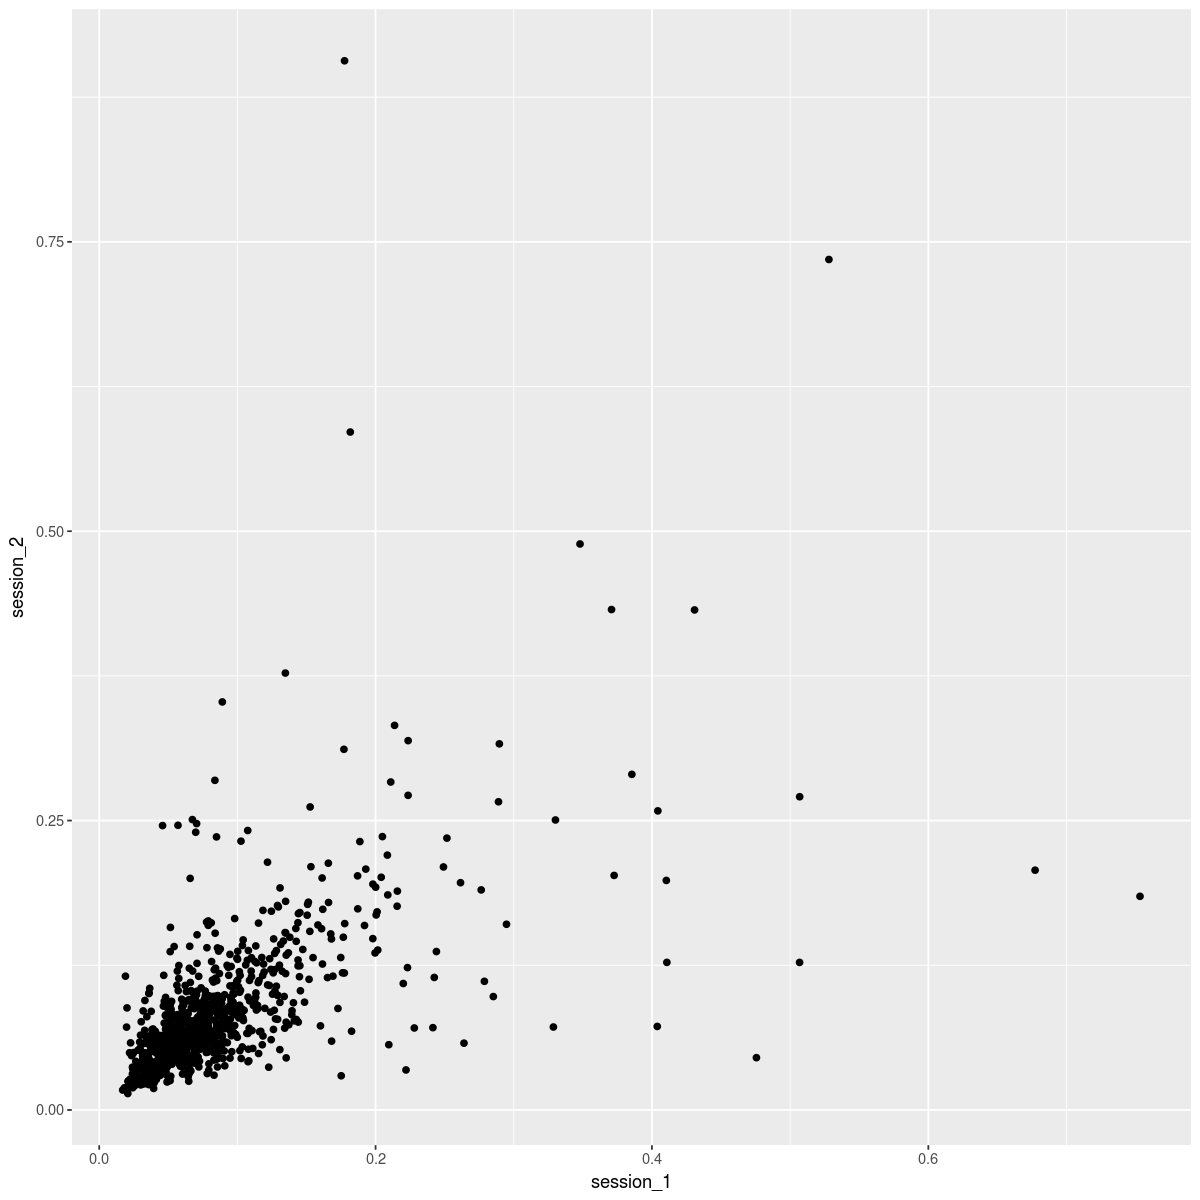

In [66]:
options(repr.plot.width=10, repr.plot.height=10)
df<-filter(df,Measure=="RMSD..Mean.")
df<-filter(df,Participant!=25296)
p1=ggplot(df,aes(x=session_1,y=session_2))+geom_point()
print(p1)

In [62]:
which(df$session_1>3)

[1] 125

In [65]:
df[125,]

,Participant,Site,Series,Measure,session_1,session_2
125,25296,UPSM_1,rest_1,RMSD..Mean.,3.289866,0.09788609
